<h1><center>  Project 3 </center> </h1> 

<center> Bruno Gomes Coelho - 9791160 </center>
<center> Gabriel de Melo Cruz - 9763043 </center>


### Imports

In [1]:
import collections

from sklearn.decomposition import PCA
import numpy as np
import pandas as pd

import networkx as nx

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set()

In [2]:
TESTING = True

In [3]:
def degree_distribution(G, hist=False, title="Degree distribution"):
    vk = dict(G.degree())
    vk = list(vk.values())  # we get only the degree values
    vk = np.array(vk)
    maxk = np.max(vk)
    mink = np.min(vk)
    kvalues= np.arange(0,maxk+1) # possible values of k
    Pk = np.zeros(maxk+1) # P(k)
    for k in vk:
        Pk[k] = Pk[k] + 1
    Pk = Pk/sum(Pk) # the sum of the elements of P(k) must to be equal to one
    
    if hist:
        plt.hist(vk, bins=range(0, maxk+1), density=True)
        plt.ylabel("Pk", fontsize=15)
        plt.xlabel("Degree", fontsize=15)
        plt.title(title, fontsize=20)
        plt.grid(True)
        plt.show(True)
    
    return kvalues, Pk

def average_degree(graph):
    degrees = graph.degree()
    return np.mean([*dict(degrees).values()])

def second_moment(graph):
    M = 0
    N = len(graph)
    for i in graph.nodes:
        M = M + graph.degree(i)**2
    M = M/N
    return M


def avg_shortest_path(graph):
    if nx.is_connected(graph) == True:
        return nx.average_shortest_path_length(graph)
    else:
        #print('We will use only the largest component')
        connected =sorted(nx.connected_component_subgraphs(graph), 
                          key=len, reverse=True)
        return nx.average_shortest_path_length(connected[0])

    
def diameter(graph):
    if nx.is_connected(graph) == True:
        return nx.diameter(graph)
    else:
        #print('We will use only the largest component')
        connected =sorted(nx.connected_component_subgraphs(graph), 
                          key=len, reverse=True)
        return nx.diameter(connected[0])

    
all_funcs = {
    "Num nodes": lambda x: len(x.nodes),
    "Avg degree": average_degree,
    "2nd Momentum": second_moment,
    "Avg shortest path": avg_shortest_path,
    "Avg clust coef": nx.average_clustering,
    "Transivity": nx.transitivity,
    "Assortativity coef": nx.degree_assortativity_coefficient,
}

   

# Q1

In [4]:
def erdos_renyi(N=100, avg_degree=20, p=None):
    if p is None:
        p = avg_degree/(N-1)
    return nx.gnp_random_graph(N, p, seed=None, directed=False)

def barabasi_albert(N=100, avg_degree=20):
    m = int(avg_degree/2)
    return nx.barabasi_albert_graph(N, m)

def watts_strogatz(N=100, avg_degree = 20, p=1):
    k = int(avg_degree/2)
    return nx.watts_strogatz_graph(N, k, p, seed=None)

graphs = {
    "Erdos Renyi": erdos_renyi,
    "Barabasi Albert": barabasi_albert,
    "Watts Strogatz (p=0.1)": lambda x: watts_strogatz(x, p=0.1),
    "Watts Strogatz (p=0.01)": lambda x: watts_strogatz(x, p=0.01),
}

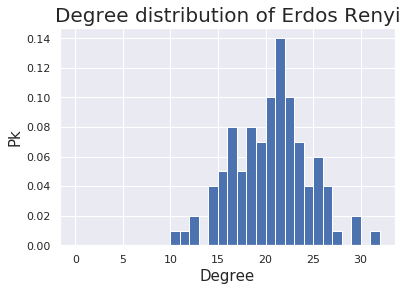

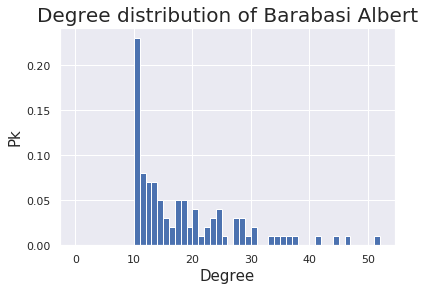

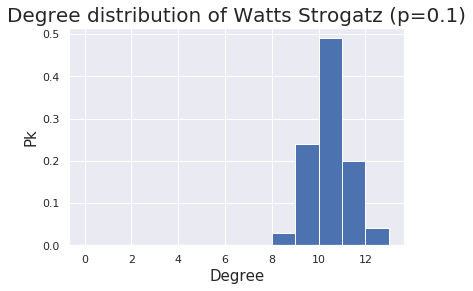

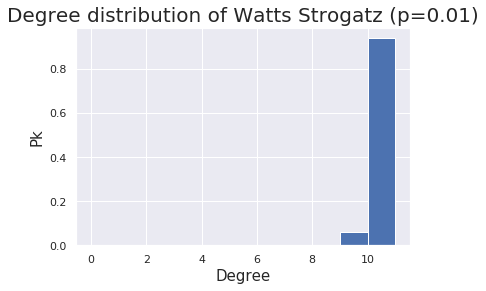

In [5]:
# Create a DF for storing all the data points for exercise 5
cols = list(all_funcs.keys())
cols.append("type")
all_data_points = pd.DataFrame(columns=cols)

# Create another DF just for mean/STD
results = pd.DataFrame(index=graphs.keys())

N = 100 if TESTING else 1000
REPS = 3 if TESTING else 10

for graph_name, graph_func in graphs.items():
    all_results = collections.defaultdict(list)
    # Calculate various time the different measures
    for idx in range(REPS):
        graph = graph_func(N)
        # Show the degree dist of a random member
        if idx == 0:
            degree_distribution(graph, hist=True, 
                                title=f"Degree distribution of {graph_name}")

        new_row = pd.Series(index=cols)
        for name, func in all_funcs.items():
            value = func(graph)
            all_results[name].append(value)
            new_row[name] = value
        new_row["type"] = graph_name
        all_data_points = all_data_points.append(new_row, ignore_index=True)
    
    # Calculate mean and std of measures
    for name in all_funcs.keys():
        all_results[name] = np.array(all_results[name])
        mean = all_results[name].mean()
        std = all_results[name].std()
        results.loc[graph_name, name + " mean"] = mean
        results.loc[graph_name, name + " std"] = std

In [6]:
results.T

,Erdos Renyi,Barabasi Albert,Watts Strogatz (p=0.1),Watts Strogatz (p=0.01)
Num nodes mean,100.000000,100.000000,100.000000,100.000000
Num nodes std,0.000000,0.000000,0.000000,0.000000
Avg degree mean,19.846667,18.000000,10.000000,10.000000
Avg degree std,0.571392,0.000000,0.000000,0.000000
2nd Momentum mean,411.193333,409.000000,101.033333,100.120000
2nd Momentum std,24.593291,5.126896,0.210608,0.048990
Avg shortest path mean,1.814074,1.860539,2.658990,4.221145
Avg shortest path std,0.008605,0.002102,0.044976,0.610064
Avg clust coef mean,0.204821,0.277771,0.484614,0.647824
Avg clust coef std,0.007891,0.006977,0.015565,0.009795


We can see by the models of Wattz Strogatz show distributions very close to the Erdos Renyi, showing a gaussian curve. However, the Barabasi Albert model shows a distribuiton that approximates a logarithm one.


---

<br>
<br>
<br>
<br>
<br>
<br>



# Q2

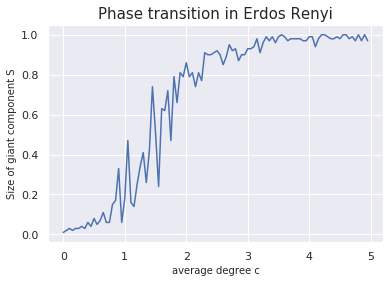

In [7]:
S = []
vk = []
for c in np.arange(0, 5, 0.05):
    p = c/(N-1)
    graph = erdos_renyi(N=N, p=p)
    connected_graph = sorted(nx.connected_component_subgraphs(graph), 
                             key=len, reverse=True)
    S.append(len(connected_graph[0])/N)
    vk.append(c)

plt.figure()
plt.plot(vk, S, 'b', label='Largest component size')
plt.xlabel("average degree c", fontsize=10)
plt.ylabel("Size of giant component S", fontsize=10)
plt.title("Phase transition in Erdos Renyi", fontsize=15)
plt.grid(True)
plt.show();

In [8]:
%%time
all_ns = [x for x in range(100, 1001, 100)]
all_ks = [4, 10, 20, 30]
path_lengths = collections.defaultdict(list)
diameters = collections.defaultdict(list)
temp = collections.defaultdict(list)

for k in all_ks:
    for n in all_ns:
        graph = erdos_renyi(N=n, avg_degree=k)
        path_lengths[k].append(all_funcs["Avg shortest path"](graph))
        temp[k].append(diameter(graph))
        value = np.array(list(dict(graph.degree).values())).mean()
        diameters[k].append(np.log10(n) / np.log10(value))
    if TESTING:
        break

CPU times: user 30.1 s, sys: 0 ns, total: 30.1 s
Wall time: 30.2 s


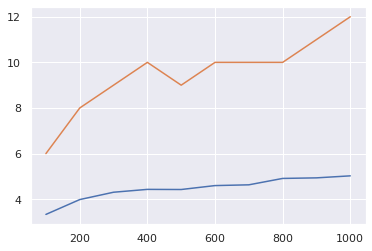

In [9]:
for k in all_ks:
    plt.plot(all_ns, diameters[k], label="small")
    plt.plot(all_ns, temp[k], label="diameter")
    break

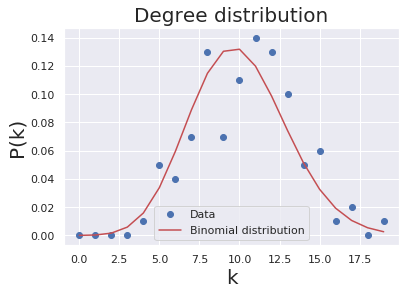

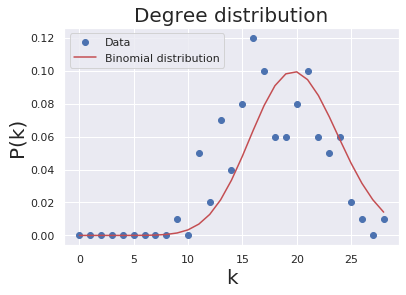

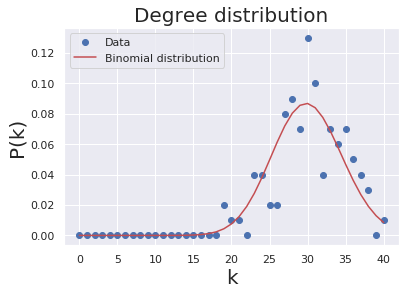

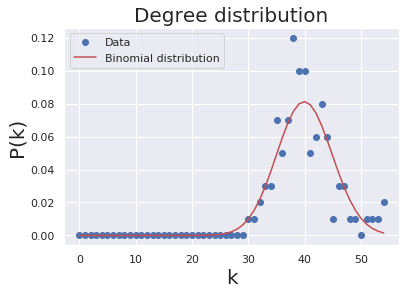

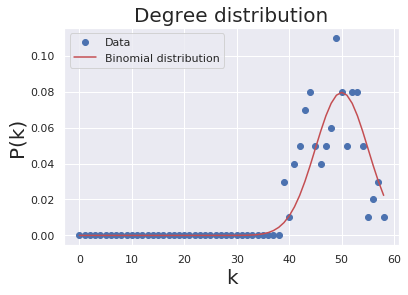

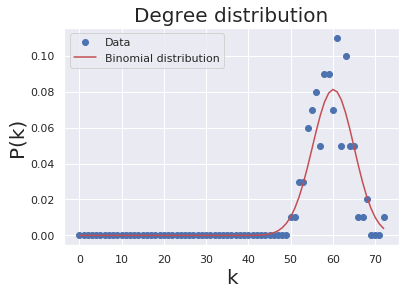

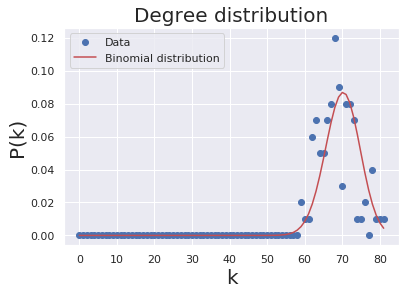

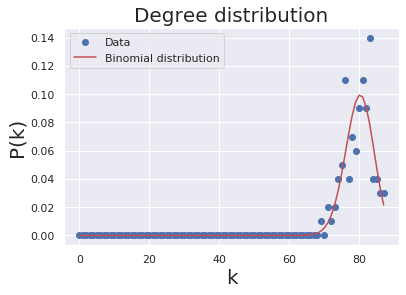

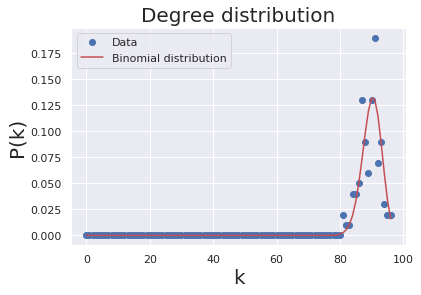

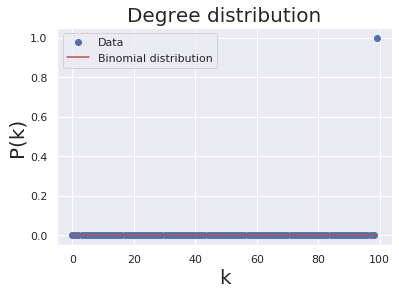

CPU times: user 4.8 s, sys: 97.8 ms, total: 4.89 s
Wall time: 4.95 s


In [10]:
%%time
all_ps = np.arange(0.1, 1.1, 0.1)
N = 100

for p in all_ps:
    graph = nx.gnp_random_graph(N, p, seed=None, directed=False)
    ks, Pk = degree_distribution(graph)
    plt.figure()
    plt.plot(ks,Pk,'bo', label='Data')
    plt.xlabel("k", fontsize=20)
    plt.ylabel("P(k)", fontsize=20)
    plt.title("Degree distribution", fontsize=20)
    plt.grid(True)
    plt.savefig('degree_dist.eps') #save the figure into a file

    ## Fitting of. binomial distribution
    from scipy.stats import binom
    pk = binom.pmf(ks, N, p)
    plt.plot(ks, pk, 'r', label='Binomial distribution')
    plt.legend()
    plt.show(True)
    
    #if TESTING:
        #break

No handles with labels found to put in legend.


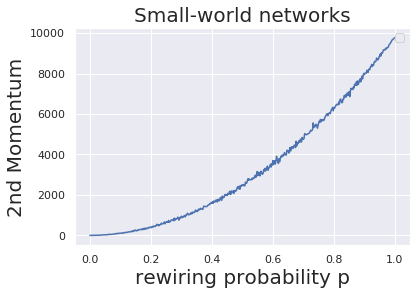

CPU times: user 3.33 s, sys: 6.49 ms, total: 3.34 s
Wall time: 3.37 s


In [11]:
%%time
lst = []

all_ps = np.arange(0, 1, 0.002)
N = 100
for p in all_ps:
    graph = nx.gnp_random_graph(N, p, seed=None, directed=False)
    lst.append(second_moment(graph))
    
plt.figure()
plt.plot(all_ps, lst)
plt.xlabel("rewiring probability p", fontsize=20)
plt.ylabel("2nd Momentum", fontsize=20)
plt.title("Small-world networks", fontsize=20)
plt.legend()
plt.grid(True)
plt.show();

# Q3

In [12]:
%%time
vcc = []
vl = []
vq = []
start = 0
for stop in [0.001, 0.01, 0.1, 1]:
    if stop == 0.001:
        continue
    for p in np.linspace(start, stop, num=10):
        graph = watts_strogatz(p=p)
        cc = nx.average_clustering(graph)
        vcc.append(cc)
        l = nx.average_shortest_path_length(graph)
        vl.append(l)
        vq.append(p)
    start = stop

CPU times: user 1.89 s, sys: 15.4 ms, total: 1.91 s
Wall time: 2.03 s


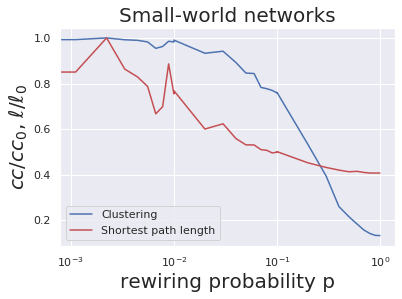

In [13]:
plt.figure()
plt.semilogx(vq, np.array(vcc)/vcc[0], 'b', label='Clustering')
plt.semilogx(vq, np.array(vl)/vl[0], 'r', label='Shortest path length')
plt.xlabel("rewiring probability p", fontsize=20)
plt.ylabel("$cc/cc_0$, $\ell/\ell_0$", fontsize=20)
plt.title("Small-world networks", fontsize=20)
plt.legend()
plt.grid(True)
plt.show();

In [14]:
%%time
lst = []
all_ps = np.linspace(0, 1, num=200)
for p in all_ps:
    graph = watts_strogatz(p=p)
    lst.append(second_moment(graph))

CPU times: user 475 ms, sys: 0 ns, total: 475 ms
Wall time: 479 ms


No handles with labels found to put in legend.


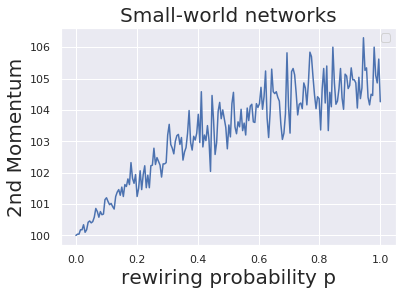

In [15]:
plt.figure()
plt.plot(all_ps, lst)
plt.xlabel("rewiring probability p", fontsize=20)
plt.ylabel("2nd Momentum", fontsize=20)
plt.title("Small-world networks", fontsize=20)
plt.legend()
plt.grid(True)
plt.show();

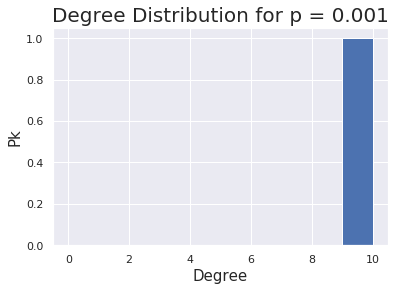

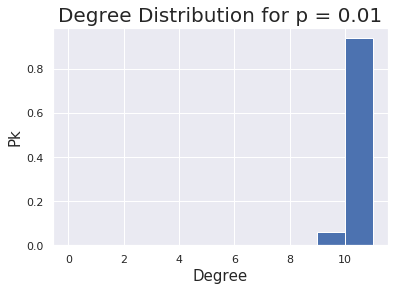

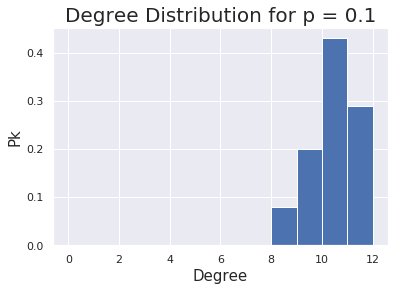

In [16]:
for p in [0.001, 0.01, 0.1]:
    graph = watts_strogatz(p=p)
    degree_distribution(graph, hist=True, 
                        title=f"Degree Distribution for p = {p}")

# Q4

In [17]:
def config_model(N=100, av_degree=8):
    N = 100
    a = 2.5
    seq = np.random.zipf(a, N) #Zipf distribution
    
    if(sum(seq)%2 != 0): # the sum of stubs have to be even
        pos = randint(0, len(seq))
        seq[pos] = seq[pos]+ 1
    
    GCM=nx.configuration_model(seq)
    
    Gcc=sorted(nx.connected_component_subgraphs(GCM), key = len, reverse=True)
    G=Gcc[0]
    return G

def erdos_renyi(N=100, avg_degree=20, p=None):
    if p is None:
        p = avg_degree/(N-1)
    return nx.gnp_random_graph(N, p, seed=None, directed=False)

def barabasi_albert(N=100, avg_degree=20):
    m = int(avg_degree/2)
    return nx.barabasi_albert_graph(N, m)

def watts_strogatz(N=100, avg_degree = 20, p=1):
    k = int(avg_degree/2)
    return nx.watts_strogatz_graph(N, k, p, seed=None)

graphs = {
    "Erdos Renyi": erdos_renyi,
    "Barabasi Albert": barabasi_albert,
    "Watts Strogatz (p=0.1)": lambda x: watts_strogatz(x, p=0.1),
    "Watts Strogatz (p=0.01)": lambda x: watts_strogatz(x, p=0.01),
    "Configuration Model": config_model,
}

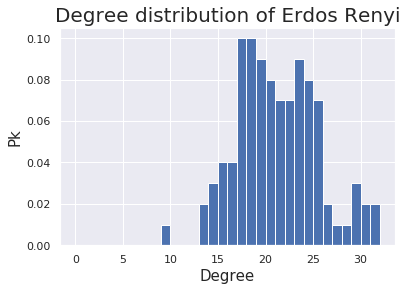

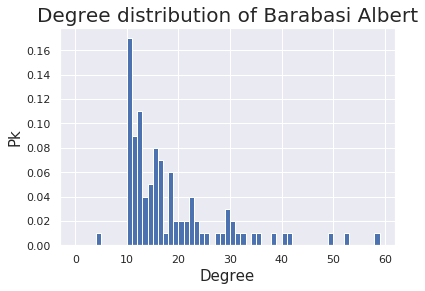

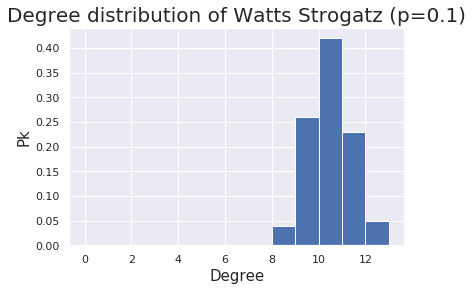

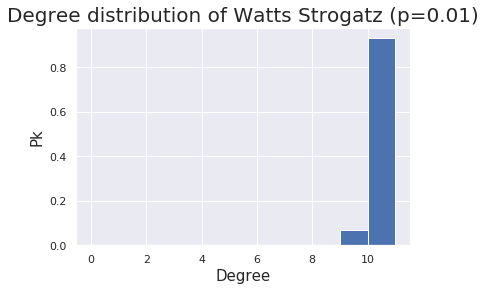

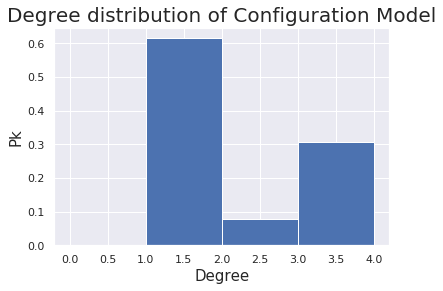

NetworkXNotImplemented: not implemented for multigraph type

In [18]:

cols = list(all_funcs.keys())
cols.append("type")
all_data_points = pd.DataFrame(columns=cols)

# Create another DF just for mean/STD
results = pd.DataFrame(index=graphs.keys())

N = 100 if TESTING else 1000
REPS = 3 if TESTING else 10

for graph_name, graph_func in graphs.items():
    all_results = collections.defaultdict(list)
    # Calculate various time the different measures
    for idx in range(REPS):
        graph = graph_func(N)
        # Show the degree dist of a random member
        if idx == 0:
            degree_distribution(graph, hist=True, 
                                title=f"Degree distribution of {graph_name}")

        new_row = pd.Series(index=cols)
        for name, func in all_funcs.items():
            value = func(graph)
            all_results[name].append(value)
            new_row[name] = value
        new_row["type"] = graph_name
        all_data_points = all_data_points.append(new_row, ignore_index=True)
    
    # Calculate mean and std of measures
    for name in all_funcs.keys():
        all_results[name] = np.array(all_results[name])
        mean = all_results[name].mean()
        std = all_results[name].std()
        results.loc[graph_name, name + " mean"] = mean
        results.loc[graph_name, name + " std"] = std

In [19]:
results.T

,Erdos Renyi,Barabasi Albert,Watts Strogatz (p=0.1),Watts Strogatz (p=0.01),Configuration Model
Num nodes mean,100.000000,100.000000,100.000000,100.000000,NaN
Num nodes std,0.000000,0.000000,0.000000,0.000000,NaN
Avg degree mean,20.280000,18.000000,10.000000,10.000000,NaN
Avg degree std,0.342150,0.000000,0.000000,0.000000,NaN
2nd Momentum mean,429.980000,411.680000,100.833333,100.100000,NaN
2nd Momentum std,14.008540,6.115314,0.049889,0.032660,NaN
Avg shortest path mean,1.807609,1.857912,2.731448,3.909966,NaN
Avg shortest path std,0.007758,0.002667,0.017351,0.133573,NaN
Avg clust coef mean,0.205118,0.280581,0.503977,0.648227,NaN
Avg clust coef std,0.003173,0.013073,0.016393,0.003365,NaN


# Q5 - Classification of networks

Choose three networks and perform the classification. Show the results by using the PCA.

Escolhemos o network hamster, human protein e US Airports:

In [26]:
all_graphs = {}
all_graphs["Hamster"] = nx.read_edgelist("../data/out.petster-friendships-hamster-uniq", 
                                         comments="%")

all_graphs["Human Protain"] = nx.read_edgelist("../data/out.proteins", comments="%")

all_graphs["US Airports"] = nx.Graph()
all_graphs["US Airports"] = nx.read_edgelist("../data/USairport500.txt", nodetype=int, data=(('weight',float),))

# Convert data to undirected and remove loops
for graph in all_graphs.keys():
    all_graphs[graph] = all_graphs[graph].to_undirected()
    all_graphs[graph].remove_edges_from(nx.selfloop_edges(all_graphs[graph]))

In [27]:
x_test = pd.DataFrame(index=all_graphs.keys(), columns=all_funcs.keys())
for graph_name, graph in all_graphs.items():
    for name, func in all_funcs.items():
        x_test.loc[graph_name, name] = func(graph)

In [28]:
x = all_data_points.drop(columns="type")
y = all_data_points["type"]
pca = PCA(n_components=2)
if not TESTING:
    assert results.isna().sum().sum() == 0
x_pca = pca.fit_transform(x)
x_test_pca = pca.transform(x_test)

Text(0.5, 0, '2nd principal component')

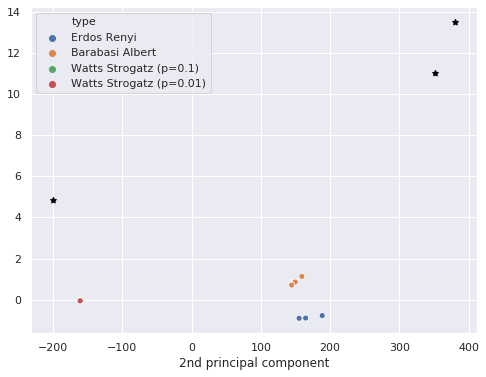

In [29]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=x_pca[:,0], y=x_pca[:,1], hue=y)
plt.scatter(x_test_pca[:,0], x_test_pca[:,1], marker=(5, 1), c="black")
plt.xlabel("1st principal component")
plt.xlabel("2nd principal component")